<a href="https://colab.research.google.com/github/sandroormeno/proyecto_dotcsv/blob/master/laberinto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%tensorflow_version 2.x

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from IPython.display import clear_output

In [0]:
PATH = "/content/drive/My Drive/Colab Notebooks/dotcsv/laberinto"
INPATH = PATH + "/in"
OUPATH  = PATH + "/out"

In [0]:
impUrls = !ls -1 "{INPATH}"

In [0]:
#impUrls

In [17]:
n = 450
tranin_n = round(n * 0.80)

# listado randomizado
randurls = np.copy(impUrls)


#np.random.seed(11) # solo para el tutorial
np.random.shuffle(randurls)

# partici+oj en train y test
tr_urls = randurls[:tranin_n]
ts_urls = randurls[tranin_n:n]

print(len(impUrls), len(tr_urls), len(ts_urls))

480 360 90


In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

# rescalar las imáganes
def resize(inimg, tgimg , height, widht):
    inimg = tf.image.resize(inimg, [height, widht])
    tgimg = tf.image.resize(tgimg, [height, widht])
    # resize_images
    #inimg = tf.image.resize(inimg, [height, widht], method=1)
    #tgimg = tf.image.resize(tgimg, [height, widht], method=1)
    
    return inimg, tgimg

    
# normalizar en el rango de [-1, +1] las imágenes
def normalize(inimg, tgimg):
    inimg  = (inimg / 127.5)-1
    tgimg =  (tgimg / 127.5)-1
    
    return inimg, tgimg 
       
# Aumentando los datos : Ramdom Crop + Flip  
@tf.function
def random_flip( inimg, tgimg ):
    
    #inimg, tgimg = resize( inimg, tgimg , 286, 286)
    
    #stacked_image = tf.stack([ inimg, tgimg ], axis =0)
    #cropped_image = tf.image.random_crop(stacked_image, size = [2, IMG_WIDTH, IMG_HEIGHT, 3])
    
    #inimg, tgimg =  cropped_image[0], cropped_image[1]
    
    #if tf.random.uniform(()) > 0.5: #np.random.random_sample(1)[0]
    if np.random.random_sample(1)[0] > 0.5:

      inimg =tf.image.flip_up_down(inimg)
      tgimg =tf.image.flip_up_down(tgimg)
        
    return inimg, tgimg    

def load_img(filename, augment=True):
    
    inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)), tf.float32)[..., :3]
    tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUPATH + '/' + filename)), tf.float32)[..., :3]
    
    inimg, tgimg = resize(inimg, tgimg , IMG_HEIGHT,  IMG_WIDTH)
    
    if augment:
        inimg, tgimg = random_flip(inimg, tgimg)
    
    inimg, tgimg = normalize(inimg, tgimg)
    
    return inimg, tgimg

def load_train_images(filename):
    return load_img(filename, True)

def load_test_images(filename):
    return load_img(filename, False)



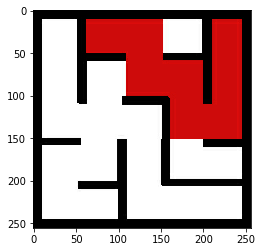

In [19]:
plt.imshow(((load_train_images(randurls[40])[1]) +1)/2)

In [0]:
# carga de datos
# creando dataset entrenamiento
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_images)
train_dataset = train_dataset.cache().shuffle(len(tr_urls))
train_dataset = train_dataset.batch(1)

# creando dataset test
test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_test_images)
test_dataset = test_dataset.batch(1)

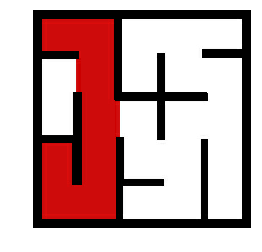

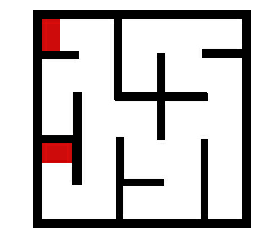

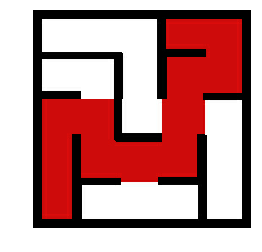

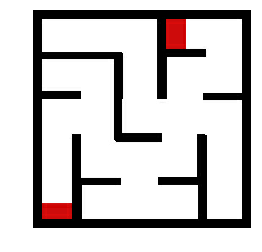

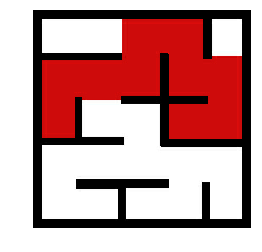

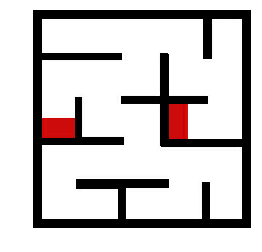

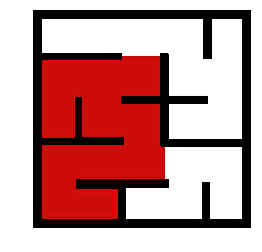

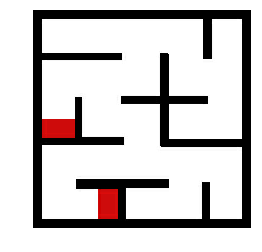

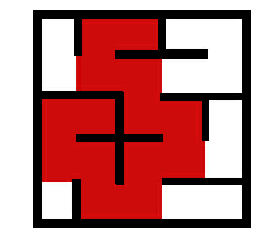

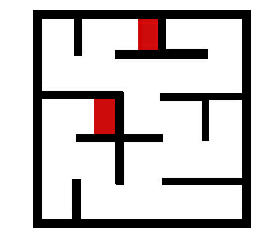

In [23]:
for inmg, tgimg in train_dataset.take(5):
    #print(inmg.shape)
    plt.imshow(((tgimg[0,...])+1)/2)
    plt.axis('off')
    plt.show()
    plt.imshow(((inmg[0,...])+1)/2)
    plt.axis('off')
    plt.show()

In [24]:
def downsample(filters, apply_batchnorm=True):
    
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    
    # Nuestra capa
    result.add(tf.keras.layers.Conv2D(filters, 
                                      kernel_size=4, 
                                      strides=2, 
                                      padding='same',
                                      kernel_initializer=initializer, 
                                      use_bias=False))
    # capa de BatchNormalization
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
                   
    # Añado una activación LeakyReLU
    result.add(tf.keras.layers.LeakyReLU())

    return result 

# prueba
downsample(93)

In [25]:
def upsample(filters, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    
    # capa convolucional
    result.add(tf.keras.layers.Conv2DTranspose(filters, 
                                               kernel_size=4, 
                                               strides=2,
                                               padding='same',
                                               kernel_initializer=initializer,
                                               use_bias=False))
    
    # capa de BatchNormalization
    result.add(tf.keras.layers.BatchNormalization())
    
    # acplico dropout si esta activo
    if apply_dropout: 
        
        result.add(tf.keras.layers.Dropout(0.5))
    # Añado una activación Relu    
    result.add(tf.keras.layers.ReLU())

    return result

upsample(34)

In [0]:
def Generator():
    
    inputs = tf.keras.layers.Input(shape=[None,None,3])
    
    down_stack = [
        downsample(64, apply_batchnorm=False), # (batchsize, 128, 128, 64)
        downsample(128),                       # (batchsize, 64, 64, 128)
        downsample(256),                       # (batchsize, 32, 32, 256)
        downsample(512),                       # (batchsize, 16, 16, 512)
        downsample(512),                       # (batchsize, 8, 8, 512)
        downsample(512),                       # (batchsize, 4, 4, 512)
        downsample(512),                       # (batchsize, 2, 2, 512)
        downsample(512),                       # (batchsize, 1, 1, 512)
    ]
    
    up_stack = [
        upsample(512, apply_dropout=True), # (batchsize, 2, 2, 1024)
        upsample(512, apply_dropout=True), # (batchsize, 4, 4, 1024)
        upsample(512, apply_dropout=True), # (batchsize, 8, 8, 1024)
        upsample(512),                     # (batchsize, 16, 16, 1024)
        upsample(256),                     # (batchsize, 32, 32, 512)
        upsample(128),                     # (batchsize, 64, 64, 256)
        upsample(64),                      # (batchsize, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    
    last = tf.keras.layers.Conv2DTranspose(filters=3, 
                                           kernel_size=4,
                                           strides=2, 
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 3)
    concat = tf.keras.layers.Concatenate()
    x = inputs
    skips = []
    
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    
    last = last(x)
        
    return tf.keras.Model(inputs=inputs, outputs=last)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


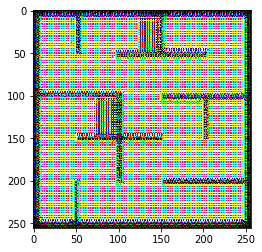

In [28]:
generator = Generator()

gen_output = generator(((inmg+1)*255), training=False)
#plt.imshow(sess.run(gen_output[0,...]))
plt.imshow(gen_output[0,...])
#gen_output.shape

In [0]:
def Discriminator():
    
    initializer = tf.random_normal_initializer(0., 0.02)

    ini = tf.keras.layers.Input(shape=[None, None, 3], name='input_img')
    gen = tf.keras.layers.Input(shape=[None, None, 3], name='gener_img')

    x = tf.keras.layers.concatenate([ini, gen]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, False)(x)                   # (bs, 128, 128, 64)
    down2 = downsample(128)(down1)                     # (bs, 64, 64, 128)
    down3 = downsample(256)(down2)                     # (bs, 32, 32, 256)
    #down4 = downsample(512)(down3)                     # (bs, 16, 16, 128)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
          

    last = tf.keras.layers.Conv2D(filters=1, 
                                  kernel_size=4, 
                                  strides=1,
                                  kernel_initializer=initializer,
                                  padding='same')(zero_pad2)  # ANTES down4
    # (bs, 16, 16, 1) down4
    # (bs, 30, 30, 1) zero_pad2

    return tf.keras.Model(inputs=[ini, gen], outputs=last)

discriminator = Discriminator()


TensorShape([1, 33, 33, 1])

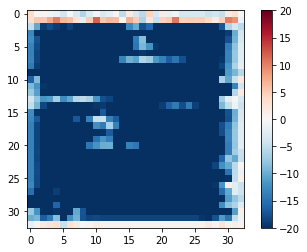

In [30]:
# probando el discriminador
discriminator = Discriminator()
disc_out = discriminator([((inmg+1)*255), gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
disc_out.shape

In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
    # Diferencia entre los TRUE por ser real y el detectado por el discriminador
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    # Diferencia entre los FALSE por ser generado  y el detectado por el discriminador
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [0]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [0]:
checkpoint_dir = PATH + "/checkpoints/"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
def generate_images(model, test_input, tar, save_filename=False, display_img = True):
    
    prediction = model(test_input, training=True)
    
    if save_filename:
        tf.keras.preprocessing.image.save_img(PATH +"/output/" + save_filename + ".jpg", prediction[0,...])
   
    plt.figure(figsize=(10,10))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Imagen de entrada', 'Real', 'Predicción']
    
    if display_img:
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            # getting the pixel values between [0, 1] to plot it.
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')
        plt.show()

In [0]:
@tf.function
def train_step(input_image, target):
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
    
        output_image = generator(input_image, training=True)

        output_gen_discr = discriminator([output_image, input_image], training=True)
    
        output_trg_discr = discriminator([target, input_image], training=True)
    
        disc_loss = discriminator_loss(output_trg_discr, output_gen_discr)
    
        gen_loss = generator_loss(output_gen_discr, output_image, target)
        
        
        generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        
        discriminator_gradients = discr_tape.gradient(disc_loss, discriminator.trainable_variables)

        
        
        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
        
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
    for epoch in range(epochs):
        
        #start = time.time()
    
        imgi =0
        # Train
        for input_image, target in dataset:
            print( "Epoca: " + str(epoch) +  " - Entrenamiento: " + str(imgi) + "/" + str(len(tr_urls)))
            imgi+=1
            train_step(input_image, target)
            clear_output(wait=True)

        imgi =0
        for inp, tar in test_dataset.take(5):
            generate_images(generator, inp, tar, str(imgi) +"_" + str(epoch), display_img = True)
            imgi+=1
        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 50 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)

        #print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

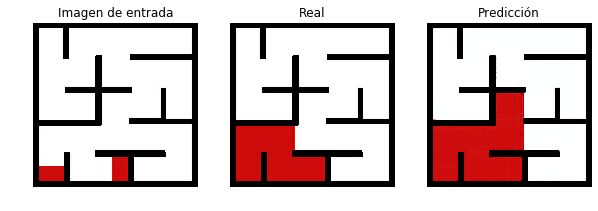

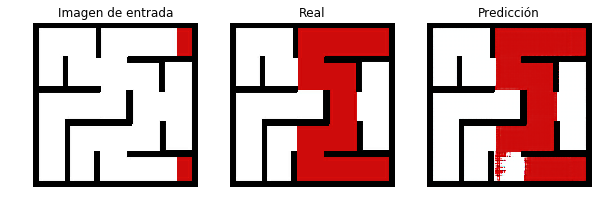

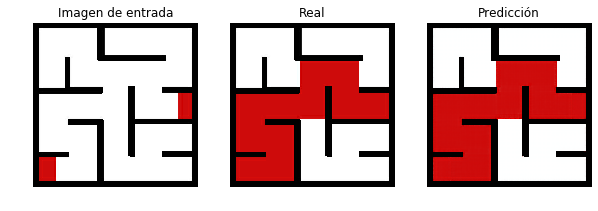

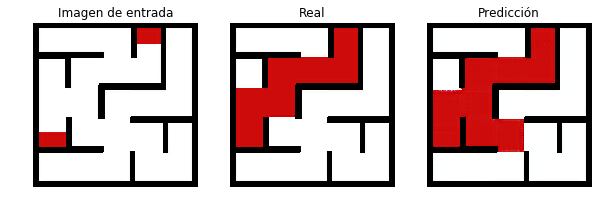

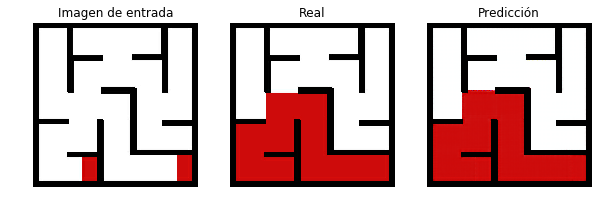

In [40]:
train(train_dataset, 100)

In [50]:
# restoring the latest checkpoint in checkpoint_dir
# esta comentado, se usa al final
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir).assert_consumed())
!ls "{checkpoint_dir}"

checkpoint		    ckpt-1.index		ckpt-2.index
ckpt-1.data-00000-of-00002  ckpt-2.data-00000-of-00002
ckpt-1.data-00001-of-00002  ckpt-2.data-00001-of-00002


In [51]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

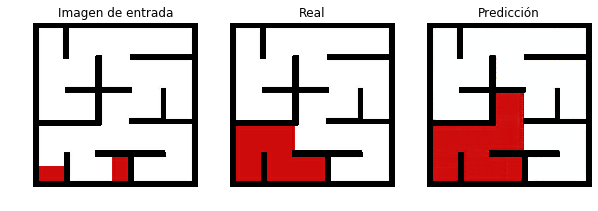

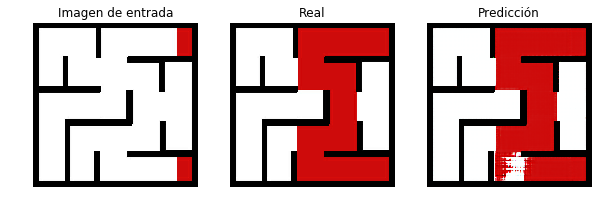

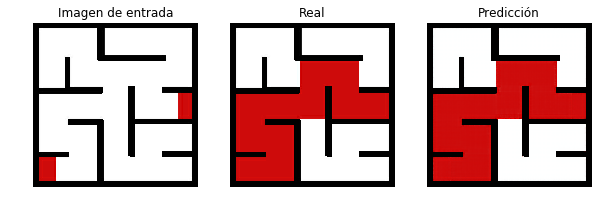

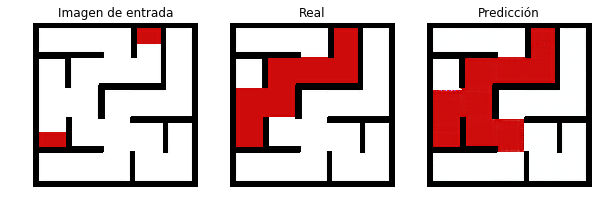

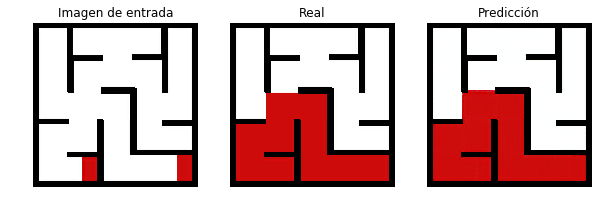

In [52]:
# Run the trained model on the entire test dataset
for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)